<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#006a79; font-size:40px; text-align:center'>Imbalanced Class Classification</h1>
</div>

__<p style='text-align:center'>Copyright (©) Machine Learning Plus. All Rights Reserved.</p>__

## Problem of Class Imbalance


Class Imbalance is the problem where the total number of data points for one class are far less than the total number of data points from another class. 

This problem is extremely common in practice and can be observed in various disciplines including fraud detection, anomaly detection, medical diagnosis, oil spillage detection, facial recognition, churn modelling etc.


## Why is it a problem?

Most of the machine learning algorithms are trained to minimize the loss in order to improve the performance. 

They work best when the number of instances of each classes are roughly equal. When the number of instances of one class far exceeds the other, the problems of class imbalance arises.

Let me explain it using an example. Let's take an example of churn modelling.

The objective of Churn Modeling is to find the customers who are most likely to 'churn' (stop being a customer / stop buying / whatever that means for the business). 

Let's say there are 1000 records in the dataset out of which 950 are 0 i.e. customer is with the company and 50 are 1 i.e. customer has churned out. The classification model with try to predict 0 in most of the time as it is minimizing the error and increasing the accuracy, if there is a model which is always predicting 0, still the accuracy would be 95%. But this is not what we want. You want the model to correctly predict 1's as well. 

If you think from business perspective, it's very important to predict who have churned out so that company can act accordingly (by recontacting them, giving discounts etc). If the customer is shown to be with the company while he/she has churned out, it's a huge loss to the company.


## How to fix this problem?

There are various techniques to handle such kind of scenerios or I should say handle imbalanced data. Let's go through the major ones by taking an example of churn modelling.


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> Churn Modelling</h2>
</div>

**Goal :** To predict if a customer has left the bank(closed his/her account) or he/she continues to be a customer

**Data :** The data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he/she continues to be a customer.

Dataset [Source](https://www.kaggle.com/shrutimechlearn/churn-modelling)

Before going into details of handling imbalanced data let's load the churn modelling data and make it ready for classification.

#### Import Libraries

In [1]:
# If you did not use anaconda, you will need to uncomment below line and install 
# !pip install numpy pandas matplotlib seaborn scikit-learn

In [2]:
# Import Libraries
import pandas as pd
import numpy as np

# Sklearn for ML 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, roc_auc_score, plot_roc_curve
from sklearn.metrics import classification_report 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# plot
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
import os

#### Load Data

In [3]:
os.getcwd()

'C:\\Users\\maste\\Documents\\Personal\\ML+\\Learning\\Logistic regression\\class imbalance'

In [4]:
churn_data = pd.read_csv('../Churn_Modelling.csv',index_col='RowNumber')

In [5]:
churn_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1.1+ MB


Once you have loaded the data, you need to pre process it before building the model. Hence let's pre process it
#### Data pre - processing

In [7]:
# Drop few columns which won't contribute to the model using domain knowldedge.
churn_data.drop(['CustomerId','Surname'],axis=1,inplace=True)

In [8]:
# Let's do one hot encoding for the column `Geo` as Logistic Regression model would be expecting numeric features
churn_data = pd.get_dummies(prefix='Geo',data=churn_data,columns=['Geography'])

In [9]:
# Rather than using one hot encoding we can do label encoding as well. Here let's use replace function rather than label encoder
churn_data = churn_data.replace(to_replace={'Gender': {'Female': 1,'Male':0}})

#### Model Building

__Function to Build the model__

In [133]:
# Define the function to create classificatio model and get the evaluation metrices
def classification_model(X,y,class_weight = None):
    
    # Split the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)
    
    # Scale the features as we don't want one independent variable to dominate the others and additionally it makes computations easy
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    # Define the model
    lr = LogisticRegression(class_weight = class_weight, random_state=0)

    # Train the model
    lr.fit(X_train, y_train)

    # Predicting target values on x_test dataset
    y_predicted = lr.predict(X_test)
    y_predicted_prob = lr.predict_proba(X_test)
    y_predicted_prob = [x[1] for x in y_predicted_prob]
    return(lr, X_test, y_test, y_predicted, y_predicted_prob)

__Function to evaluate the model__

In [134]:
# Define the function to get the evaluation metrices
def compute_evaluation_metric(model, x_test, y_actual, y_predicted, y_predicted_prob):
    cm = confusion_matrix(y_actual, y_predicted)
    print("\n Accuracy Score : ",accuracy_score(y_actual,y_predicted))
    print("\n AUC Score : ", roc_auc_score(y_actual, y_predicted_prob))
    print("\n Confusion Matrix : \n", cm)
    TP = sum([1 if ((i==1) & (j==1)) else 0 for (i, j) in zip(y_test, y_predicted)])
    TN = sum([1 if ((i==0) & (j==0)) else 0 for (i, j) in zip(y_test, y_predicted)])
    FP = sum([1 if ((i==0) & (j==1)) else 0 for (i, j) in zip(y_test, y_predicted)])
    FN = sum([1 if ((i==1) & (j==0)) else 0 for (i, j) in zip(y_test, y_predicted)])
    # Sensitivity, recall
    TPR = round(TP/(TP+FN), 4)
    # Specificity
    TNR = round(TN/(TN+FP), 4)
    # False Pos Rate
    FPR = round(FP/(FP+TN), 4)
    # False Neg rate
    FNR = round(FN/(TP+FN), 4)
    print("\n Classification Report : \n",classification_report(y_actual, y_predicted))
    print("TPR, TNR, FPR, FNR:" , TPR, TNR, FPR, FNR)
    print("\n ROC curve : \n")
    plot_roc_curve(model, x_test, y_actual)
    plt.show()

__Build the model__

In [135]:
# Build the model on original dataset and get the evaluation metrices
X_original = churn_data.drop(['Exited'],axis=1)
y_original = churn_data.Exited
lr, X_test, y_test, y_predicted, y_predicted_prob = classification_model(X_original,y_original)

__Evaluate the model__

In [136]:
print(sum(y_predicted_prob))

688.5914276776749


In [13]:
#another way of getting errors values
TP=TN=FP=FN =0
for (i, j) in zip(y_test, y_predicted):
    if i == j==1:
        TP+=1
    if i==j==0:
        TN +=1
    if i==0 and j==1:
        FP +=1
    if i==1 and j==0:
        FN+=1
print(TP,TN,FP,FN)
    

154 2511 106 529



 Accuracy Score :  0.8075757575757576

 AUC Score :  0.7701927536531887

 Confusion Matrix : 
 [[2511  106]
 [ 529  154]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      2617
           1       0.59      0.23      0.33       683

    accuracy                           0.81      3300
   macro avg       0.71      0.59      0.61      3300
weighted avg       0.78      0.81      0.77      3300

TPR, TNR, FPR, FNR: 0.2255 0.9595 0.0405 0.7745

 ROC curve : 



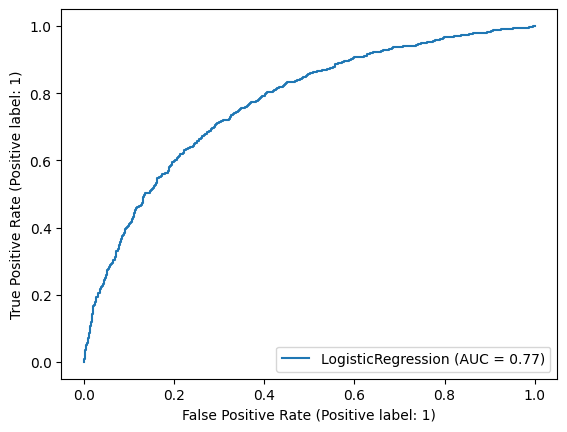

In [14]:
# Get evaluation metrices
compute_evaluation_metric(lr, X_test, y_test, y_predicted, y_predicted_prob)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h4 style='margin:10px 5px'> Inferences:</h4>
</div>

- The accuracy of the model is good. 
- You might think that the model is good by looking at the accuracy but if you check the confusion matrix and classification report, it has poor recall, which means, it is not able to capture the +ve (1's) properly. 
- Besides, it also has a high False Negative Rate. That is, the model predicted as safe, but they ended up defaulting, which is concerning as well.

One of the possible reasons for this behavious might be class imbalance i.e one class is domination other class. Let's see if that's the reason.

#### Check distribution of target/y variable

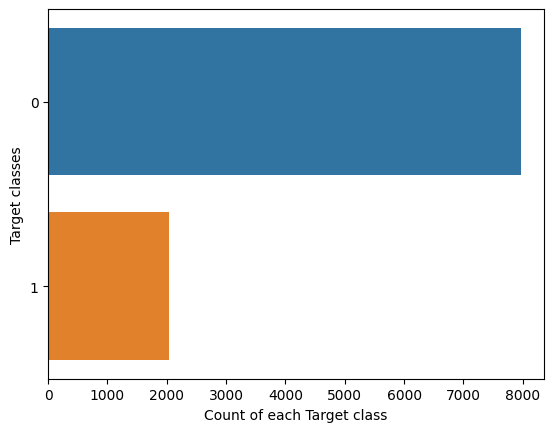

In [15]:
# Check the distribution of y variable to see if it's a case of unbalanced class
sns.countplot(y=churn_data.Exited ,data=churn_data)
plt.xlabel("Count of each Target class")
plt.ylabel("Target classes")
plt.show()

In [16]:
# Check the count of target class
print("Class count on original data : \n" , churn_data.Exited.value_counts())

Class count on original data : 
 0    7963
1    2037
Name: Exited, dtype: int64


<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h4 style='margin:10px 5px'> Inferences:</h4>
</div>

- No. of rows for target class 0 are 7963 while for target class 1 it's 2037, i.e 25% of class 0

It can be seen clearly that it's a case of class imbalance. Let's look at different ways of tacking the problem. We will go through them one by one:

<a id="1"></a> <br>
<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 1. Upsampling Minority Class</h2>
</div>

In upsamling minority class, rows with minority class are repeatedly sampled over and over till it reaches the same size as the majority class. We can specify the number of rows we want to achieve as well.

Let's use `resample` function from sklearn library.

**Steps to follow** :
- Divide the data into majority and minority class
- Use `resample` function from sklearn.utils to upsample the minority class, set the number of sample (`n_sample`) to be equal to that of majority class.
- Concatenate the majority data and upsampled minority class to get the balanced data.

First, store the count of minority class and majority class in variables, these values will be used while sampling the dataset

In [17]:
# Get the count of minority class and majority class, it will be used while sampling the dataset
n_rows_majority = churn_data.Exited.value_counts()[0]
n_rows_minority = churn_data.Exited.value_counts()[1]

print("No. of rows in majority class 0 : ", n_rows_majority)
print("No. of rows in minority class 1 : ", n_rows_minority)

No. of rows in majority class 0 :  7963
No. of rows in minority class 1 :  2037


Now, when you have the count of minority and majority class let's upsample the data.

In [18]:
# import resample function from sklearn.utils module
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = churn_data[churn_data.Exited==0]
df_minority = churn_data[churn_data.Exited==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=n_rows_majority,    # to match majority class
                                 random_state=0) # to get reproducible results

df_minority_upsampled.shape

(7963, 13)

In [19]:
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
print("Class count on upsampled data : \n" , df_upsampled.Exited.value_counts())

Class count on upsampled data : 
 0    7963
1    7963
Name: Exited, dtype: int64


Now, the row count of both the classes is 7963, let's use the same classification algorithms we used earlier

__Build__

In [20]:
# Build the model on balanced dataset and get the evaluation metrices
X = df_upsampled.drop(['Exited'],axis=1)
y = df_upsampled.Exited
lr, X_test, y_test, y_predicted, y_predicted_prob = classification_model(X, y)

__Evaluate__


 Accuracy Score :  0.7092846270928462

 AUC Score :  0.777963914913335

 Confusion Matrix : 
 [[1893  713]
 [ 815 1835]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.70      0.73      0.71      2606
           1       0.72      0.69      0.71      2650

    accuracy                           0.71      5256
   macro avg       0.71      0.71      0.71      5256
weighted avg       0.71      0.71      0.71      5256

TPR, TNR, FPR, FNR: 0.6925 0.7264 0.2736 0.3075

 ROC curve : 



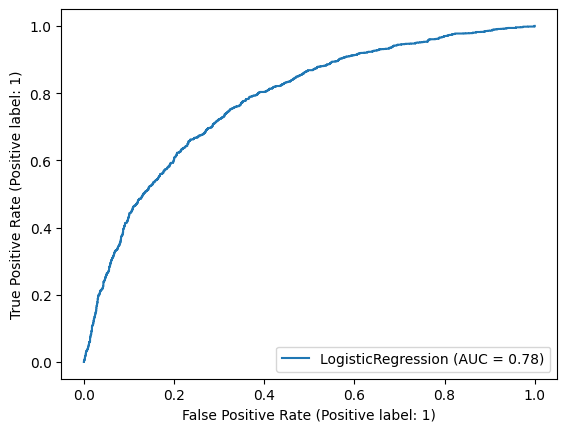

In [21]:
# Get evaluation metrices
compute_evaluation_metric(lr, X_test, y_test, y_predicted, y_predicted_prob)

In [22]:
base = ["reference",  0.2255, 0.9595, 0.0405, 0.7745]
upsample_minority = ["upsample_minority",  0.6925, 0.7264, 0.2736, 0.3075]

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h4 style='margin:10px 5px'> Inferences:</h4>
</div>

Reference: TPR, TNR, FPR, FNR: 0.2255 0.9595 0.0405 0.7745

__Accuracy of the model has gone down__ from 81% to 71%. BUT..

- TPR has improved from 22.5% to 69%
- TNR has reduced from 95% to 72.6% 
- FNR has improved 77.45% to 30.75%

TPR and FNR has sinificantly improved. So __even though we have a 'Bad' model in terms of accuracy. This model is way better for all practical purposes__, because, it is able to capture more defaulters overall (TPR) and mark less of defaulters as non-defaulters (FNR). For a bank that focusses on redu

So, it's very important that you choose the sensible models.

However, this model say's NO more often, which might irk some customers. Let's see if we can improve that in future.

<a id="2"></a> <br>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 2. Undersampling Majority Class</h2>
</div>

In undersampling majority class, rows with majority class are randomly down sampled to be of the same size as the minority class. We can specify the number of rows we want to acheive as well.

Let's use `resample` function from sklearn library

**Steps to follow** :
- Divide the data into mojority and minority class
- Use `resample` function from sklearn.utils to downsample the majority class, set the number of sample (`n_sample`) to be equal to that of minority class.
- Concatinate the minority class data and downsampled majority class data


In [23]:
# import resample function from sklearn.utils module
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = churn_data[churn_data.Exited==0]
df_minority = churn_data[churn_data.Exited==1]
 

__Downsample Majority Class with Resample__

In [24]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=2037,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.Exited.value_counts()

0    2037
1    2037
Name: Exited, dtype: int64

Now, the row count of both the classes is 7963, let's use the same classification algorithms we used earlier

__Build Model__

In [25]:
# Build the model on balanced dataset and get the evaluation metrices
X = df_downsampled.drop(['Exited'],axis=1)
y = df_downsampled.Exited
lr, X_test, y_test, y_predicted, y_predicted_prob = classification_model(X, y)

__Evaluate__


 Accuracy Score :  0.7144981412639405

 AUC Score :  0.7820393759286777

 Confusion Matrix : 
 [[473 199]
 [185 488]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.72      0.70      0.71       672
           1       0.71      0.73      0.72       673

    accuracy                           0.71      1345
   macro avg       0.71      0.71      0.71      1345
weighted avg       0.71      0.71      0.71      1345

TPR, TNR, FPR, FNR: 0.7251 0.7039 0.2961 0.2749

 ROC curve : 



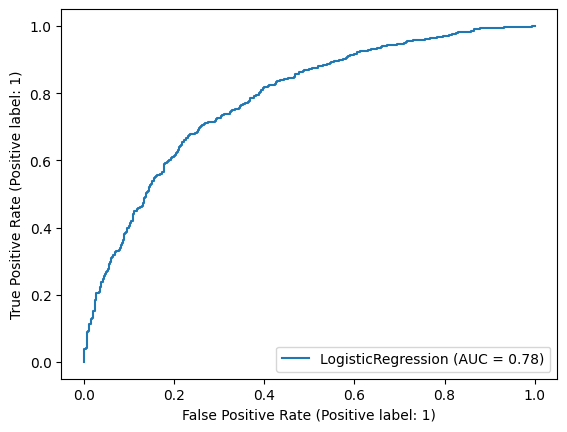

In [26]:
# Get evaluation metrices
compute_evaluation_metric(lr, X_test, y_test, y_predicted, y_predicted_prob)

In [27]:
# name, accuracy, F1, ROC, TPR, TNR, FPR, FNR
base                = ["reference",  0.81, 0.33, 0.77, 0.2255, 0.9595, 0.0405, 0.7745]
upsample_minority   = ["upsample_minority",  0.71, 0.71, 0.78, 0.6925, 0.7264, 0.2736, 0.3075]
downsample_majority = ["downsample_majority", 0.71, 0.72, 0.78, 0.7251, 0.7039, 0.2961, 0.2749]

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h4 style='margin:10px 5px'> Inferences:</h4>
</div>

- The accuracy has reduced as compared to the model buit on original dataset but now the model is in a good state to precict the 1's as well, the precision recall and f-1 score has improved for class 1 as well.

- Overall, an improvement over both the base models and the upsampling the minority class based approach.

<a id="3"></a> <br>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 3. Cluster Centroids with imbalanced-learn </h2>
</div>

In cluster centroids approach, the majority class is undersampled. But, when undersampling, instead of selecting rows of the majority class randomly, it generates new samples. 

How are these new samples generated?

If you want to generate 1000 new samples, the majority class is clustered into 1000 clusters using K-Means clustering and the centroid of each of the clusters are taken as the new data points. 

Sometimes, this is dramatically improve the performance of the models. 

Reference: [Imbalanced Learn Documentation](https://imbalanced-learn.org/stable/under_sampling.html#prototype-generation)

In [28]:
!pip install imblearn==0.9

ERROR: Could not find a version that satisfies the requirement imblearn==0.9 (from versions: 0.0)
ERROR: No matching distribution found for imblearn==0.9


In [29]:
import sklearn, imblearn
print(sklearn.__version__)
print(imblearn.__version__)

1.1.3
0.11.0


In [30]:
# Installation. YOU MIGHT HAVE TO TERMINATE JUPYTER LAB/NOTEBOOK SESSION AND RESTART.
#!pip install -U imbalanced-learn

In [31]:
# import RandomUnderSampler function from imblearn.under_sampling
from imblearn.under_sampling import ClusterCentroids

In [32]:
X_centroid=X_original.copy()
y_centroid = y_original.copy()
X_centroid

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geo_France,Geo_Germany,Geo_Spain
RowNumber,,,,,,,,,,,,
1,619,1,42,2,0.00,1,1,1,101348.88,1,0,0
2,608,1,41,1,83807.86,1,0,1,112542.58,0,0,1
3,502,1,42,8,159660.80,3,1,0,113931.57,1,0,0
4,699,1,39,1,0.00,2,0,0,93826.63,1,0,0
5,850,1,43,2,125510.82,1,1,1,79084.10,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9996,771,0,39,5,0.00,2,1,0,96270.64,1,0,0
9997,516,0,35,10,57369.61,1,1,1,101699.77,1,0,0
9998,709,1,36,7,0.00,1,0,1,42085.58,1,0,0


In [33]:
#X_centroid['Balance']=X_centroid['Balance'].astype('int64')
#X_centroid['EstimatedSalary']=X_centroid['EstimatedSalary'].astype('int64')

#convert all columns to int64 as centroidcluster is throwing error message for flat64 and uint8
X_centroid=X_centroid.astype('int64')

In [34]:
X_centroid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   CreditScore      10000 non-null  int64
 1   Gender           10000 non-null  int64
 2   Age              10000 non-null  int64
 3   Tenure           10000 non-null  int64
 4   Balance          10000 non-null  int64
 5   NumOfProducts    10000 non-null  int64
 6   HasCrCard        10000 non-null  int64
 7   IsActiveMember   10000 non-null  int64
 8   EstimatedSalary  10000 non-null  int64
 9   Geo_France       10000 non-null  int64
 10  Geo_Germany      10000 non-null  int64
 11  Geo_Spain        10000 non-null  int64
dtypes: int64(12)
memory usage: 1015.6 KB


In [35]:
# Undersample majority class keeping clusters in mind.
cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_resample(X_centroid,y_centroid)

In [36]:
y_resampled.value_counts()

0    2037
1    2037
Name: Exited, dtype: int64

__Build Classification__

In [37]:
# Build the model on balanced dataset and get the evaluation metrices
X = X_resampled
y = y_resampled
lr, X_test, y_test, y_predicted, y_predicted_prob =  classification_model(X, y)

In [38]:
lr.coef_

array([[-0.02921021,  0.3813222 ,  0.71188284,  0.04471914, -0.55024593,
         0.2764209 ,  0.20091438, -0.23191726,  0.01579189,  2.61797098,
         2.78153481,  2.11368773]])

__Evaluate Performance__


 Accuracy Score :  0.8617100371747212

 AUC Score :  0.930618941484469

 Confusion Matrix : 
 [[534 138]
 [ 48 625]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.79      0.85       672
           1       0.82      0.93      0.87       673

    accuracy                           0.86      1345
   macro avg       0.87      0.86      0.86      1345
weighted avg       0.87      0.86      0.86      1345

TPR, TNR, FPR, FNR: 0.9287 0.7946 0.2054 0.0713

 ROC curve : 



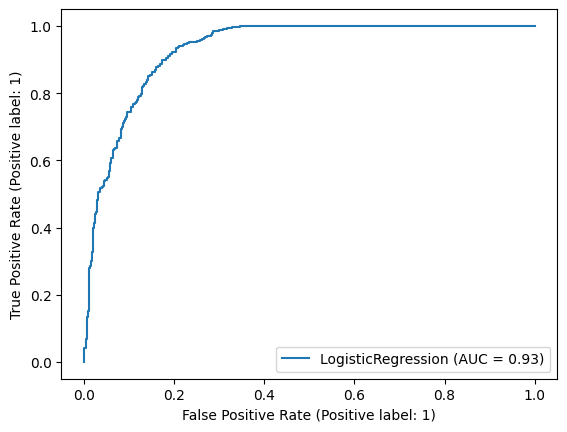

In [39]:
# Get evaluation metrices
compute_evaluation_metric(lr, X_test, y_test, y_predicted, y_predicted_prob)

In [40]:
# name, accuracy, F1, ROC, TPR, TNR, FPR, FNR
base                = ["reference",  0.81, 0.33, 0.77, 0.2255, 0.9595, 0.0405, 0.7745]
upsample_minority   = ["upsample_minority",  0.71, 0.71, 0.78, 0.6925, 0.7264, 0.2736, 0.3075]
downsample_majority = ["downsample_majority", 0.71, 0.72, 0.78, 0.7251, 0.7039, 0.2961, 0.2749]
cluster_centroids   = ["cluster_cetroids", 0.861, 0.87, 0.93, 0.9272, 0.7842, 0.2158, 0.0728]

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h4 style='margin:10px 5px'> Inferences:</h4>
</div>

- The accuracy has reduced as compared to the model buit on original dataset but now the model is in a good state to precict the 1's as well, the precision recall and f-1 score has improved for class 1 as well.

<a id="4"></a> <br>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 4.  Random over-sampling with imbalanced-learn</h2>
</div>

In random oversampling minority class with imblearn, new rows of the minority class are created by introducing small variations into the existing rows of minority class.

Let's use `RandomOverSampler` function from imblearn.over_sampling library

In [41]:
y_original.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [42]:
# import RandomOverSampler function from imblearn.over_sampling
from imblearn.over_sampling import RandomOverSampler

# Fit the RandomOverSampler
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_original, y_original)

y_ros.value_counts()

1    7963
0    7963
Name: Exited, dtype: int64

In [43]:
# Build the model on balanced dataset and get the evaluation metrices
X = X_ros
y = y_ros
lr, X_test, y_test, y_predicted, y_predicted_prob = classification_model(X, y)

__Evaluate Performance__


 Accuracy Score :  0.7068112633181126

 AUC Score :  0.7724624578360145

 Confusion Matrix : 
 [[1879  745]
 [ 796 1836]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.70      0.72      0.71      2624
           1       0.71      0.70      0.70      2632

    accuracy                           0.71      5256
   macro avg       0.71      0.71      0.71      5256
weighted avg       0.71      0.71      0.71      5256

TPR, TNR, FPR, FNR: 0.6976 0.7161 0.2839 0.3024

 ROC curve : 



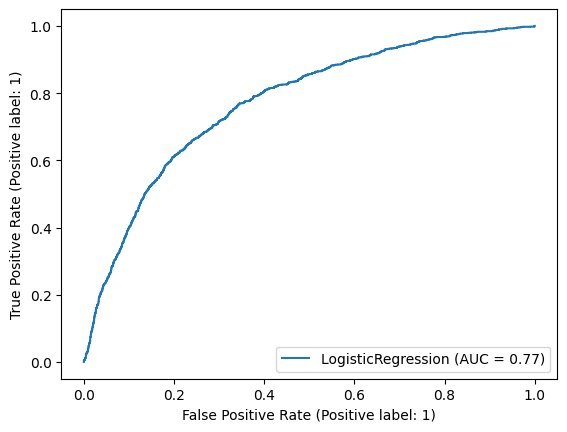

In [44]:
# Get evaluation metrices
compute_evaluation_metric(lr, X_test, y_test, y_predicted, y_predicted_prob)

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h4 style='margin:10px 5px'> Inferences:</h4>
</div>

- The accuracy has reduced as compared to the model buit on original dataset but now the model is in a good state to precict the 1's as well, the precision recall and f-1 score has improved for class 1 as well.

<a id="5"></a> <br>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 5. Over-sampling: SMOTE</h2>
</div>

SMOTE(Synthetic Minority Oversampling Technique) - As the name suggests, it's an oversampling technique where synthetic samples are created for the minority class. 

In order to create a synthetic instance, It finds the K-nearest neighbors of every minority row/record, then it selects one of them randomly, post that it computes linear interpolations to produce a new minority row/record in the neighborhood. This process get's repeated and the rows for minority class increases till the class gets balanced.

It is very popular because it overcomes the problem of overfitting caused by random oversampling.

We'll use ratio='minority' to resample the minority class.

In [45]:
# import RandomOverSampler function from imblearn.over_sampling
from imblearn.over_sampling import SMOTE

# Fit the SMOTE
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_original, y_original)

y_sm.value_counts()

1    7963
0    7963
Name: Exited, dtype: int64

In [46]:
# Build the model on balanced dataset and get the evaluation metrices
X = X_sm
y = y_sm
lr, X_test, y_test, y_predicted, y_predicted_prob = classification_model(X,y)

__Evaluate Performance__


 Accuracy Score :  0.8093607305936074

 AUC Score :  0.888866622803766

 Confusion Matrix : 
 [[2235  389]
 [ 613 2019]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.78      0.85      0.82      2624
           1       0.84      0.77      0.80      2632

    accuracy                           0.81      5256
   macro avg       0.81      0.81      0.81      5256
weighted avg       0.81      0.81      0.81      5256

TPR, TNR, FPR, FNR: 0.7671 0.8518 0.1482 0.2329

 ROC curve : 



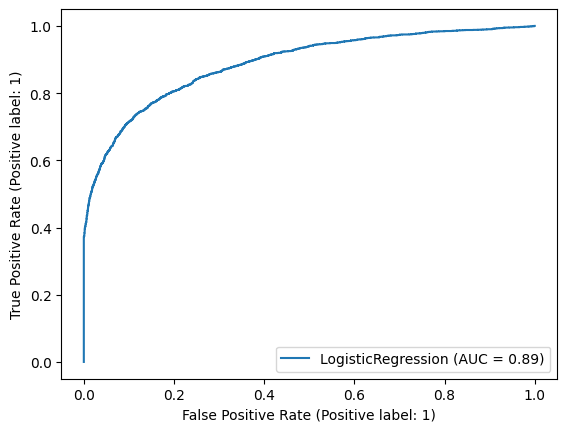

In [47]:
# Get evaluation metrices
compute_evaluation_metric(lr, X_test, y_test, y_predicted, y_predicted_prob)

In [48]:
# name, accuracy, F1, ROC, TPR, TNR, FPR, FNR
base                = ["reference",  0.81, 0.33, 0.77, 0.2255, 0.9595, 0.0405, 0.7745]
upsample_minority   = ["upsample_minority",  0.71, 0.71, 0.78, 0.6925, 0.7264, 0.2736, 0.3075]
downsample_majority = ["downsample_majority", 0.71, 0.72, 0.78, 0.7251, 0.7039, 0.2961, 0.2749]
cluster_centroids   = ["cluster_cetroids", 0.8557, 0.87, 0.93, 0.9272, 0.7842, 0.2158, 0.0728]
SMOTE_oversample    = ["SMOTE_oversample", 0.81, 0.80, 0.89, 0.7743, 0.8472, 0.1528, 0.2257]

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h4 style='margin:10px 5px'> Inferences:</h4>
</div>

- Does a good job of detecting the 1's (defaulters) and a better job of handling out more loans to genuine non-defaulters. So, less conservative than cluster centroids based approach.

__Mini Challenge__: Try to improve this performance by adjusting sampling_strategy (0.30, 0.35, 0.40, 0.45, 0.5, 0.55, 0.60, 0.65) 

<a id="6"></a> <br>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 6. ADASYN </h2>
</div>

- Imblearn [API Ref](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.ADASYN.html)
- ADASYN [Paper](https://www.ele.uri.edu/faculty/he/PDFfiles/adasyn.pdf)

ADASYN(Adaptive Synthetic Sampling Apraoch): As the name suggests, it's a sampling technique which adaptively generates syntetic minority data samples according to their distribution. i.e it generates more rows/records in the low density regions of feature space and less rows/records in the high density regions of feature space.

'''_ADASYN is based on the idea of adaptively generating minority data samples according to their distributions: more synthetic data is generated for minority class samples that are harder to learn compared to those minority samples that are easier to learn._'''

__Resample with ADASYN__

In [49]:
# import ADASYN function from imblearn.over_sampling
from imblearn.over_sampling import ADASYN 

ada = ADASYN(sampling_strategy= "auto", random_state=42, n_neighbors=5)

# Fit the ADASYN
X_res, y_res = ada.fit_resample(X_original, y_original)
y_res.value_counts()

1    7977
0    7963
Name: Exited, dtype: int64

__Build Model__

In [50]:
# Build the model on balanced dataset and get the evaluation metrices
X = X_res
y = y_res
lr, X_test, y_test, y_predicted, y_predicted_prob = classification_model(X,y)

__Evaluate__


 Accuracy Score :  0.8118228473674206

 AUC Score :  0.8904229126790559

 Confusion Matrix : 
 [[2232  412]
 [ 578 2039]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.79      0.84      0.82      2644
           1       0.83      0.78      0.80      2617

    accuracy                           0.81      5261
   macro avg       0.81      0.81      0.81      5261
weighted avg       0.81      0.81      0.81      5261

TPR, TNR, FPR, FNR: 0.7791 0.8442 0.1558 0.2209

 ROC curve : 



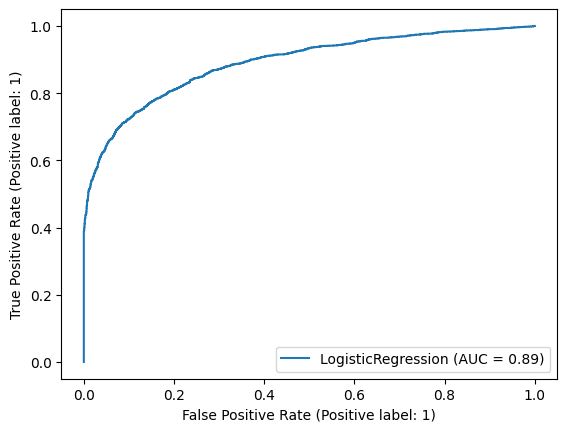

In [51]:
# Get evaluation metrices
compute_evaluation_metric(lr, X_test, y_test, y_predicted, y_predicted_prob)

In [52]:
# name, accuracy, F1, ROC, TPR, TNR, FPR, FNR
base                = ["reference",  0.81, 0.33, 0.77, 0.2255, 0.9595, 0.0405, 0.7745]
upsample_minority   = ["upsample_minority",  0.71, 0.71, 0.78, 0.6925, 0.7264, 0.2736, 0.3075]
downsample_majority = ["downsample_majority", 0.71, 0.72, 0.78, 0.7251, 0.7039, 0.2961, 0.2749]
cluster_centroids   = ["cluster_cetroids", 0.8557, 0.87, 0.93, 0.9272, 0.7842, 0.2158, 0.0728]
SMOTE_oversample    = ["SMOTE_oversample", 0.81, 0.80, 0.89, 0.7743, 0.8472, 0.1528, 0.2257]
ADASYN_oversample   = ["ADASYN_oversample", 0.81, 0.80, 0.89, 0.7791, 0.8442, 0.1558, 0.2209]

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h4 style='margin:10px 5px'> Inferences:</h4>
</div>

The results are very similar to what we had for SMOTE, may be a marginal improvement in TPR. Can be attributed to how similar these two algorithms are. 

<a id="6"></a> <br>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 7. Near Miss</h2>
</div>

__Resample__

In [53]:
# NearMiss
from imblearn.under_sampling import NearMiss 

nm = NearMiss(version=1)

# Fit the NearMiss 
X_res, y_res = nm.fit_resample(X_original, y_original)
y_res.value_counts()

0    2037
1    2037
Name: Exited, dtype: int64

__Train Model__

In [54]:
# Build the model on balanced dataset and get the evaluation metrices
X = X_res
y = y_res
lr, X_test, y_test, y_predicted, y_predicted_prob = classification_model(X,y)

__Evaluate__


 Accuracy Score :  0.9033457249070632

 AUC Score :  0.9492676714073445

 Confusion Matrix : 
 [[645  27]
 [103 570]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.86      0.96      0.91       672
           1       0.95      0.85      0.90       673

    accuracy                           0.90      1345
   macro avg       0.91      0.90      0.90      1345
weighted avg       0.91      0.90      0.90      1345

TPR, TNR, FPR, FNR: 0.847 0.9598 0.0402 0.153

 ROC curve : 



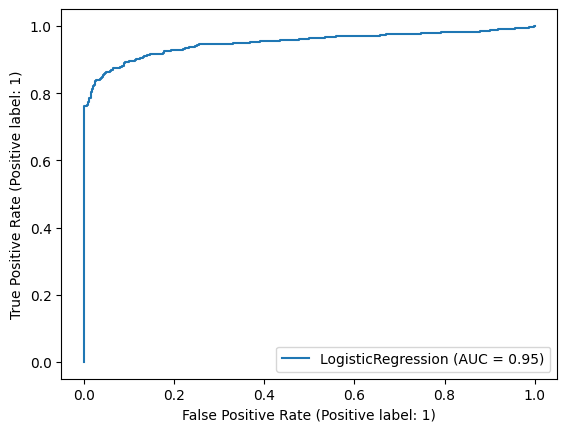

In [55]:
# Get evaluation metrices
compute_evaluation_metric(lr, X_test, y_test, y_predicted, y_predicted_prob)

In [56]:
# name, accuracy, F1, ROC, TPR, TNR, FPR, FNR
base                = ["reference",  0.81, 0.33, 0.77, 0.2255, 0.9595, 0.0405, 0.7745]
upsample_minority   = ["upsample_minority",  0.71, 0.71, 0.78, 0.6925, 0.7264, 0.2736, 0.3075]
downsample_majority = ["downsample_majority", 0.71, 0.72, 0.78, 0.7251, 0.7039, 0.2961, 0.2749]
cluster_centroids   = ["cluster_cetroids", 0.8557, 0.87, 0.93, 0.9272, 0.7842, 0.2158, 0.0728]
SMOTE_oversample    = ["SMOTE_oversample", 0.81, 0.80, 0.89, 0.7743, 0.8472, 0.1528, 0.2257]
ADASYN_oversample   = ["ADASYN_oversample", 0.81, 0.80, 0.89, 0.7791, 0.8442, 0.1558, 0.2209]
nearmiss_v1         = ["nearmiss_v1", 0.90, 0.90, .95, 0.847, 0.9598, 0.0402, 0.153]

__Inference:__

1. Nearmiss v1 has very good accuracy, ROC, improved TPR and the best TNR at 95.9%. If chose, tt will a very good job of giving out loans to the genuine non-defaulters. Less conservative. Does a good job of identifying the defaulters as well.

<a id="6"></a> <br>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 8. Tomek Links</h2>
</div>

In [57]:
y_original.count()

10000

In [58]:
y_original.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [59]:
from imblearn.under_sampling import TomekLinks 
TL = TomekLinks()
X_res, y_res = TL.fit_resample(X_original, y_original)

__Train__

In [60]:
y_res.value_counts()

0    7002
1    2037
Name: Exited, dtype: int64

In [61]:
y_res.count()

9039

In [62]:
# Build the model on balanced dataset and get the evaluation metrices
X = X_res
y = y_res
lr, X_test, y_test, y_predicted, y_predicted_prob = classification_model(X,y)

__Evaluate__


 Accuracy Score :  0.7884679852497486

 AUC Score :  0.772786552580706

 Confusion Matrix : 
 [[2196  110]
 [ 521  156]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.81      0.95      0.87      2306
           1       0.59      0.23      0.33       677

    accuracy                           0.79      2983
   macro avg       0.70      0.59      0.60      2983
weighted avg       0.76      0.79      0.75      2983

TPR, TNR, FPR, FNR: 0.2304 0.9523 0.0477 0.7696

 ROC curve : 



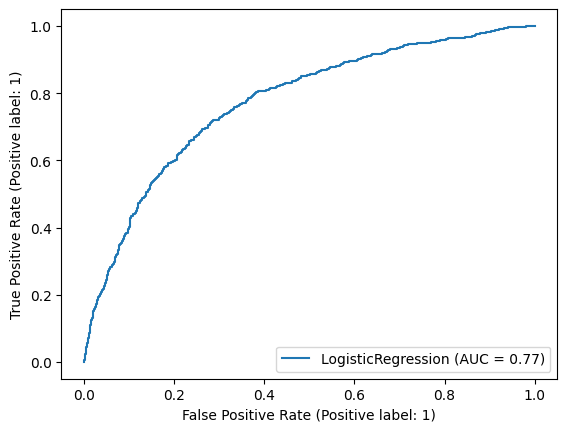

In [63]:
# Get evaluation metrices
compute_evaluation_metric(lr, X_test, y_test, y_predicted, y_predicted_prob)

In [64]:
# name, accuracy, F1, ROC, TPR, TNR, FPR, FNR
base                = ["reference",  0.81, 0.33, 0.77, 0.2255, 0.9595, 0.0405, 0.7745]
upsample_minority   = ["upsample_minority",  0.71, 0.71, 0.78, 0.6925, 0.7264, 0.2736, 0.3075]
downsample_majority = ["downsample_majority", 0.71, 0.72, 0.78, 0.7251, 0.7039, 0.2961, 0.2749]
cluster_centroids   = ["cluster_cetroids", 0.8557, 0.87, 0.93, 0.9272, 0.7842, 0.2158, 0.0728]
SMOTE_oversample    = ["SMOTE_oversample", 0.81, 0.80, 0.89, 0.7743, 0.8472, 0.1528, 0.2257]
ADASYN_oversample   = ["ADASYN_oversample", 0.81, 0.80, 0.89, 0.7791, 0.8442, 0.1558, 0.2209]
nearmiss_v1         = ["nearmiss_v1", 0.90, 0.90, .95, 0.847, 0.9598, 0.0402, 0.153]
tomek               = ["Tomek", 0.94, 0.93, .96, 0.8838, 0.981, 0.019, 0.1162]

__Inference:__

Beats NearMiss on Accuracy, F1 and AUC score. Even on TPR and TNR as well. All round better performance. 

__SMOTE TOMEK__

In [65]:
from imblearn.combine import SMOTETomek 
ST = SMOTETomek(random_state=100)
X_res, y_res = ST.fit_resample(X_original, y_original)

__Train__

In [66]:
y_res.value_counts()

0    6853
1    6853
Name: Exited, dtype: int64

In [67]:
# Build the model on balanced dataset and get the evaluation metrices
X = X_res
y = y_res
lr, X_test, y_test, y_predicted, y_predicted_prob = classification_model(X,y)

__Evaluate__


 Accuracy Score :  0.8125138182622154

 AUC Score :  0.8930712717363795

 Confusion Matrix : 
 [[1914  307]
 [ 541 1761]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.78      0.86      0.82      2221
           1       0.85      0.76      0.81      2302

    accuracy                           0.81      4523
   macro avg       0.82      0.81      0.81      4523
weighted avg       0.82      0.81      0.81      4523

TPR, TNR, FPR, FNR: 0.765 0.8618 0.1382 0.235

 ROC curve : 



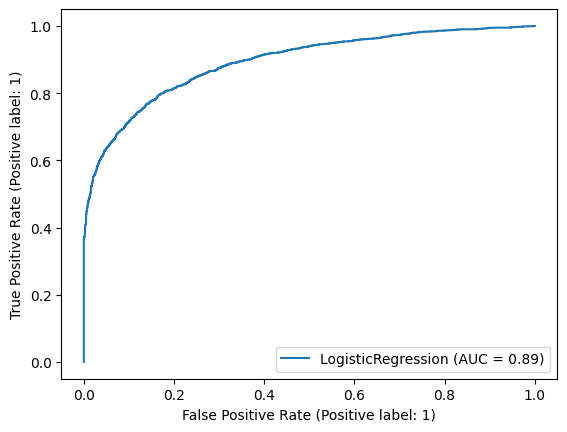

In [68]:
# Get evaluation metrices
compute_evaluation_metric(lr, X_test, y_test, y_predicted, y_predicted_prob)

In [69]:
# name, accuracy, F1, ROC, TPR, TNR, FPR, FNR
base                = ["reference",  0.81, 0.33, 0.77, 0.2255, 0.9595, 0.0405, 0.7745]
upsample_minority   = ["upsample_minority",  0.71, 0.71, 0.78, 0.6925, 0.7264, 0.2736, 0.3075]
downsample_majority = ["downsample_majority", 0.71, 0.72, 0.78, 0.7251, 0.7039, 0.2961, 0.2749]
cluster_centroids   = ["cluster_cetroids", 0.8557, 0.87, 0.93, 0.9272, 0.7842, 0.2158, 0.0728]
SMOTE_oversample    = ["SMOTE_oversample", 0.81, 0.80, 0.89, 0.7743, 0.8472, 0.1528, 0.2257]
ADASYN_oversample   = ["ADASYN_oversample", 0.81, 0.80, 0.89, 0.7791, 0.8442, 0.1558, 0.2209]
nearmiss_v1         = ["nearmiss_v1", 0.90, 0.90, .95, 0.847, 0.9598, 0.0402, 0.153]
tomek               = ["Tomek", 0.94, 0.93, .96, 0.8838, 0.981, 0.019, 0.1162]
tomek_smote         = ["TomekSMOTE", 0.94, 0.94, .97, 0.8944, 0.991, 0.009, 0.1056]

__Inference__

Beats Tomek performance marginally, across the board.

<a id="6"></a> <br>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 9. Edited Nearest Neighbours</h2>
</div>

__with Repeated Edited Neighbours and All KNN__

In [70]:
from imblearn.under_sampling import EditedNearestNeighbours 
ENN = EditedNearestNeighbours()
X_res, y_res = ENN.fit_resample(X_original, y_original)

In [71]:
y_res.value_counts()

0    4172
1    2037
Name: Exited, dtype: int64

__Train Model__

In [72]:
# Build the model on balanced dataset and get the evaluation metrices
X = X_res
y = y_res
lr, X_test, y_test, y_predicted, y_predicted_prob = classification_model(X,y)

__Evaluate__


 Accuracy Score :  0.7535383113714007

 AUC Score :  0.7845723412577686

 Confusion Matrix : 
 [[1244  140]
 [ 365  300]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      1384
           1       0.68      0.45      0.54       665

    accuracy                           0.75      2049
   macro avg       0.73      0.67      0.69      2049
weighted avg       0.74      0.75      0.74      2049

TPR, TNR, FPR, FNR: 0.4511 0.8988 0.1012 0.5489

 ROC curve : 



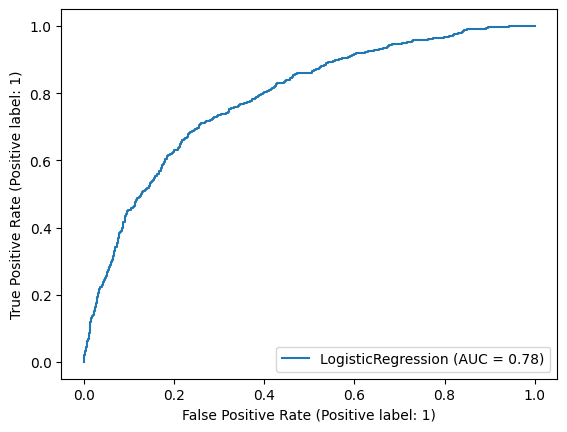

In [73]:
# Get evaluation metrices
compute_evaluation_metric(lr, X_test, y_test, y_predicted, y_predicted_prob)

In [74]:
# name, accuracy, F1, ROC, TPR, TNR, FPR, FNR
base                = ["reference",  0.81, 0.33, 0.77, 0.2255, 0.9595, 0.0405, 0.7745]
edited_nn           = ["edited_nn",  0.75, 0.54, 0.78, 0.4511, 0.8988, 0.1012, 0.5489]


__Right Way: Resample after train-test split__

In [75]:
# Define the function to create classificatio model and get the evaluation metrices
def classification_model(X,y,class_weight = None):
    # Split the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)
    
    ENN = EditedNearestNeighbours()
    X_train, y_train = ENN.fit_resample(X_train, y_train)
    
    # Scale the features as we don't want one independent variable to dominate the others and additionally it makes computations easy
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    # Define the model
    lr = LogisticRegression(class_weight = class_weight, random_state=0)

    # Train the model
    lr.fit(X_train, y_train)

    # Predicting target values on x_test dataset
    y_predicted = lr.predict(X_test)
    y_predicted_prob = lr.predict_proba(X_test)
    y_predicted_prob = [x[1] for x in y_predicted_prob]
    return(lr, X_test, y_test, y_predicted, y_predicted_prob)

__Resample and build model__

In [76]:
# Build the model on balanced dataset and get the evaluation metrices
X = X_res
y = y_res
lr, X_test, y_test, y_predicted, y_predicted_prob = classification_model(X_original, y_original)

__Compute Evaluation Metric__


 Accuracy Score :  0.786060606060606

 AUC Score :  0.7644632376101524

 Confusion Matrix : 
 [[2271  346]
 [ 360  323]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.86      0.87      0.87      2617
           1       0.48      0.47      0.48       683

    accuracy                           0.79      3300
   macro avg       0.67      0.67      0.67      3300
weighted avg       0.78      0.79      0.79      3300

TPR, TNR, FPR, FNR: 0.4729 0.8678 0.1322 0.5271

 ROC curve : 



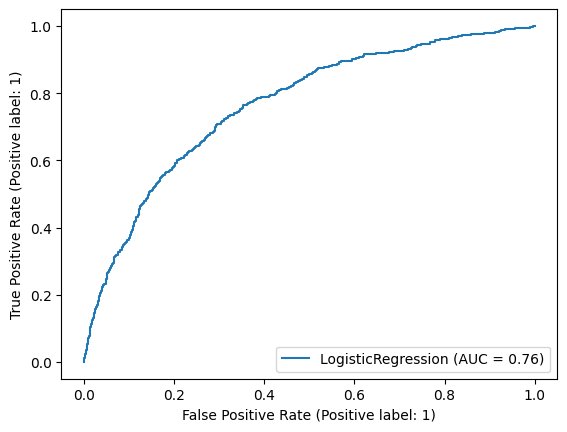

In [77]:
# Get evaluation metrices
compute_evaluation_metric(lr, X_test, y_test, y_predicted, y_predicted_prob)

In [78]:
# name, accuracy, F1, ROC, TPR, TNR, FPR, FNR
base                = ["reference",  0.81, 0.33, 0.77, 0.2255, 0.9595, 0.0405, 0.7745]
edited_nn           = ["edited_nn",  0.75, 0.54, 0.78, 0.4511, 0.8988, 0.1012, 0.5489]
edited_nn_r         = ["edited_nn_r",0.78, 0.48, 0.76, 0.4729, 0.8678, 0.1322, 0.5271]

<a id="7"></a> <br>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 9. Cost Sensitive Learning</h2>
</div>

Lot of sklearn algrothims have been designed in a way so that they can handle such class imbalance by passing an parameter itself.

You can use class_weight = 'balanced' in such cases. Let's see how to set the parameter in Logistic Regression and Random Forecast Classifier

In [79]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight = 'balanced')

__Compute class Weight__

_Weighting Formula:_

__weight = n_sample / (n_classes * n_samples_with_class)__


In [80]:
n_classes = y_original.nunique()
n_samples = len(y_original)
print(n_classes, n_samples)

2 10000


In [81]:
print(y_original.value_counts())
zeros, ones = y_original.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64


In [82]:
weight_0 = n_samples / (n_classes * zeros)
weight_1 = n_samples / (n_classes * ones)
print(weight_0, weight_1)

0.6279040562602034 2.454590083456063


In [83]:
weights = {0: weight_0, 1: weight_1}
weights

{0: 0.6279040562602034, 1: 2.454590083456063}

In [84]:
# Build the model on unbalanced dataset and use class_weight = 'balanced' for logistic regression and get the evaluation metrices
lr, X_test, y_test, y_predicted, y_predicted_prob = classification_model(X_original, y_original, class_weight = weights)

__Evaluate__

In [85]:
lr.coef_

array([[-0.08300323,  0.3010916 ,  0.85231413, -0.07032297,  0.41000807,
        -0.10168341, -0.01343144, -0.39086746,  0.04248305, -0.14079309,
         0.23490042, -0.07018467]])


 Accuracy Score :  0.5512121212121213

 AUC Score :  0.7650428468886004

 Confusion Matrix : 
 [[1216 1401]
 [  80  603]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.94      0.46      0.62      2617
           1       0.30      0.88      0.45       683

    accuracy                           0.55      3300
   macro avg       0.62      0.67      0.54      3300
weighted avg       0.81      0.55      0.59      3300

TPR, TNR, FPR, FNR: 0.8829 0.4647 0.5353 0.1171

 ROC curve : 



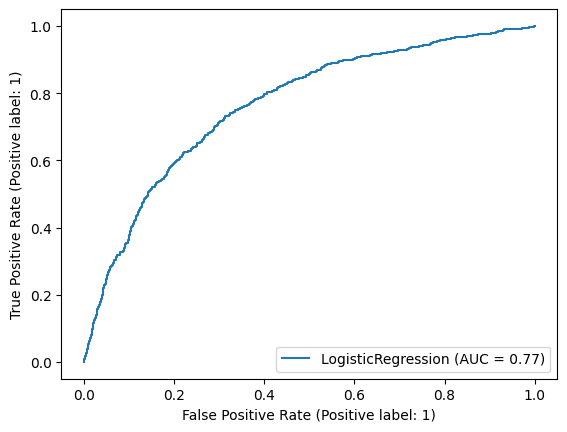

In [86]:
compute_evaluation_metric(lr, X_test, y_test, y_predicted, y_predicted_prob)

In [87]:
# name, accuracy, F1, ROC, TPR, TNR, FPR, FNR
base                = ["reference",  0.81, 0.33, 0.77, 0.2255, 0.9595, 0.0405, 0.7745]

# cost sensitive
class_weight_logit  = ["logit_CW", 0.55, 0.45, .76, 0.88, 0.46, 0.53, 0.11]

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h4 style='margin:10px 5px'> Inferences:</h4>
</div>

- The accuracy has reduced as compared to the model buit on original dataset but now the model is in a good state to precict the 1's as well. The TPR has significantly improved and TNR has been compromised a bit.

<a id="9"></a> <br>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 10. Cost Sensitive Learning with XGBoost <br>
(Class weighted XGBoost)</h2>
</div>

XGBoost short for Extreme Gradient Boosting is an efficient implementation of the Gradient boosting algorithm, which by itself is powerful machine learning algorithm.  

In [88]:
pip install xgboost==1.5.2

Note: you may need to restart the kernel to use updated packages.


_Import and check version_

In [89]:
import xgboost
xgboost.__version__

'1.5.2'

In [90]:
from xgboost import XGBClassifier

In [91]:
# Define the function to create classificatio model and get the evaluation metrices
def classification_model(X,y,scale_pos_weight = None):
    
    # Split the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)
    
    # Scale the features as we don't want one independent variable to dominate the others and additionally it makes computations easy
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    # Define the model
    xg = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=0)

    # Train the model
    xg.fit(X_train, y_train)

    # Predicting target values on x_test dataset
    y_predicted = xg.predict(X_test)
    y_predicted_prob = xg.predict_proba(X_test)
    y_predicted_prob = [x[1] for x in y_predicted_prob]
    return(xg, X_test, y_test, y_predicted, y_predicted_prob)

In [92]:
# Define the function to get the evaluation metrices
def compute_evaluation_metric(model, x_test, y_actual, y_predicted, y_predicted_prob):
    cm = confusion_matrix(y_actual, y_predicted)
    print("\n Accuracy Score : ",accuracy_score(y_actual,y_predicted))
    print("\n AUC Score : ", roc_auc_score(y_actual, y_predicted_prob))
    print("\n Confusion Matrix : \n", cm)
    TP = sum([1 if ((i==1) & (j==1)) else 0 for (i, j) in zip(y_test, y_predicted)])
    TN = sum([1 if ((i==0) & (j==0)) else 0 for (i, j) in zip(y_test, y_predicted)])
    FP = sum([1 if ((i==0) & (j==1)) else 0 for (i, j) in zip(y_test, y_predicted)])
    FN = sum([1 if ((i==1) & (j==0)) else 0 for (i, j) in zip(y_test, y_predicted)])
    # Sensitivity, recall
    TPR = round(TP/(TP+FN), 4)
    # Specificity
    TNR = round(TN/(TN+FP), 4)
    # False Pos Rate
    FPR = round(FP/(FP+TN), 4)
    # False Neg rate
    FNR = round(FN/(TP+FN), 4)
    print("\n Classification Report : \n",classification_report(y_actual, y_predicted))
    print("TPR, TNR, FPR, FNR:" , TPR, TNR, FPR, FNR)
    print("\n ROC curve : \n")
    plot_roc_curve(model, x_test, y_actual)
    plt.show()

In [93]:
# Train
xg, X_test, y_test, y_predicted, y_predicted_prob = classification_model(X_original, y_original)

[11:03:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.



 Accuracy Score :  0.8590909090909091

 AUC Score :  0.8543630983584638

 Confusion Matrix : 
 [[2483  134]
 [ 331  352]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.88      0.95      0.91      2617
           1       0.72      0.52      0.60       683

    accuracy                           0.86      3300
   macro avg       0.80      0.73      0.76      3300
weighted avg       0.85      0.86      0.85      3300

TPR, TNR, FPR, FNR: 0.5154 0.9488 0.0512 0.4846

 ROC curve : 



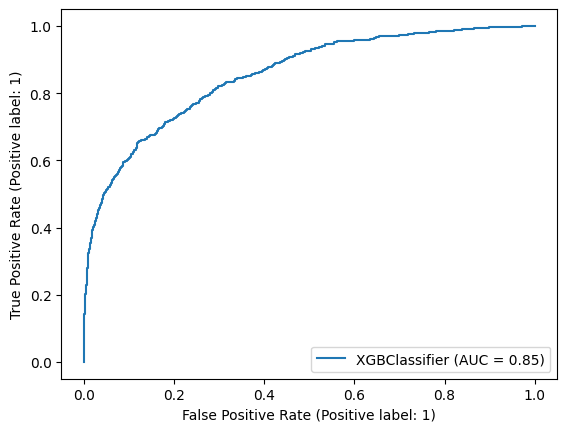

In [94]:
compute_evaluation_metric(xg, X_test, y_test, y_predicted, y_predicted_prob)

__Class Weighted XGBoost__

In [95]:
# Train
xg, X_test, y_test, y_predicted, y_predicted_prob = classification_model(X_original, y_original, scale_pos_weight=4)

[11:03:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.



 Accuracy Score :  0.8224242424242424

 AUC Score :  0.8486263092260258

 Confusion Matrix : 
 [[2261  356]
 [ 230  453]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.91      0.86      0.89      2617
           1       0.56      0.66      0.61       683

    accuracy                           0.82      3300
   macro avg       0.73      0.76      0.75      3300
weighted avg       0.84      0.82      0.83      3300

TPR, TNR, FPR, FNR: 0.6633 0.864 0.136 0.3367

 ROC curve : 



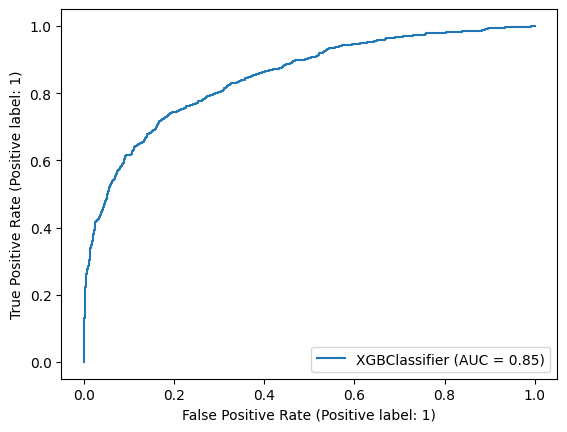

In [96]:
compute_evaluation_metric(xg, X_test, y_test, y_predicted, y_predicted_prob)

In [97]:
# name, accuracy, F1, ROC, TPR, TNR, FPR, FNR
base                = ["reference",  0.81, 0.33, 0.77, 0.2255, 0.9595, 0.0405, 0.7745]

xgboost             = ["xgboost",  0.85, 0.60, 0.8543, 0.5154, 0.9488, 0.0512, 0.4846]

# cost sensitive
class_weight_xg     = ["xgboost_CW", 0.82, 0.61, .8523, 0.6647, 0.8659, 0.1341, 0.3353]

### XGbosst with other example 

In [98]:
#define dataset
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
from collections import Counter
X,y=make_classification(n_samples=10000,n_features=2,n_redundant=0,n_clusters_per_class=2,weights=[0.99],flip_y=0,random_state=7)


In [99]:
np.unique(y,return_counts=True)

(array([0, 1]), array([9900,  100], dtype=int64))

In [100]:
data=np.column_stack((X,y))
df=pd.DataFrame(data,columns=['X1','X2','Y'])
df



,X1,X2,Y
0,0.220848,2.537372,0.0
1,-3.154395,-1.374187,0.0
2,-0.581750,-0.049262,0.0
3,-0.292545,1.409977,0.0
4,-0.274265,1.580173,0.0
...,...,...,...
9995,-0.586564,0.766582,0.0
9996,-0.193914,-0.678589,0.0
9997,-1.542903,0.488502,0.0
9998,-0.677937,-0.925575,0.0


In [101]:
counter=Counter(y)
counter.items()

dict_items([(0, 9900), (1, 100)])

[   0    1    2 ... 9997 9998 9999]
[ 112  224  238  428  566  592  662  724  729  735  846  954 1004 1090
 1092 1260 1471 1636 1714 1838 1899 1905 2184 2237 2243 2314 2382 2393
 2412 2483 2534 2636 2714 2791 2812 3138 3286 3301 3327 3407 3417 3517
 3710 3862 3996 3998 4028 4434 4462 4574 4738 4765 4889 5241 5245 5379
 5521 5885 5982 5993 6059 6079 6083 6132 6226 6472 6514 6599 6759 6766
 6893 6937 7084 7288 7679 7741 7764 7900 8240 8321 8434 8518 8627 8633
 8839 8908 9073 9093 9142 9145 9336 9389 9395 9461 9519 9622 9666 9834
 9914 9976]


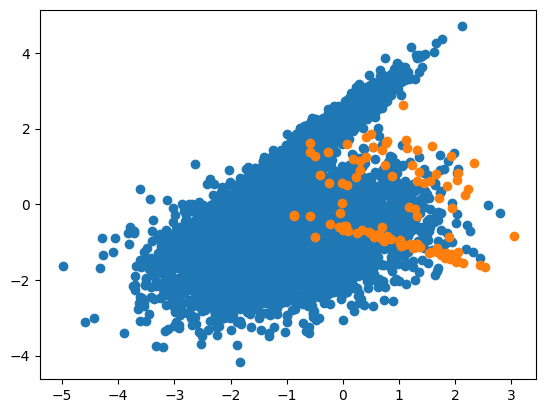

In [103]:
from numpy import where
for label,_ in counter.items():
    row_ix=where(y==label)[0]
    print(row_ix)
    plt.scatter(X[row_ix,0],X[row_ix,1],label=str(label))
plt.show()


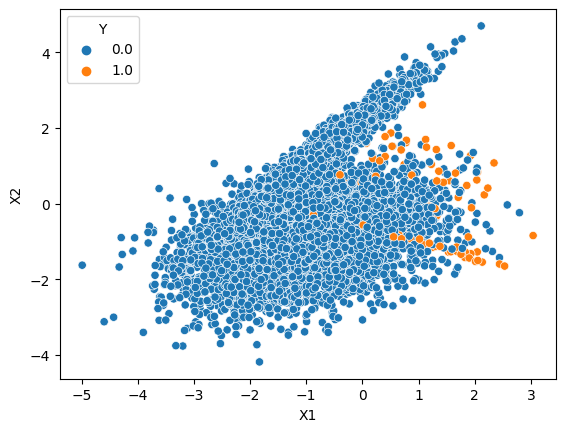

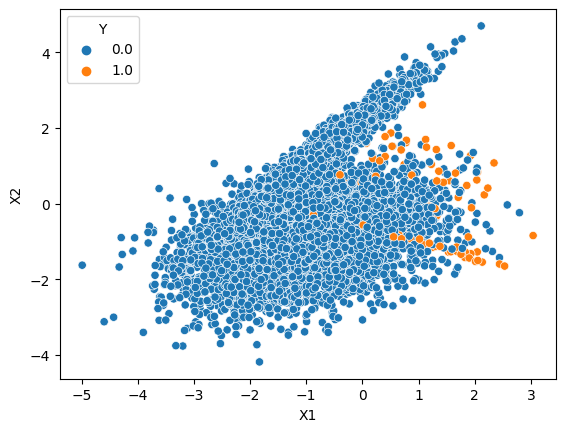

In [104]:
for cls,clsCounts in enumerate(df['Y'].value_counts()):
    #print(f"class is {cls}")
    row_id=where(df['Y']==cls)
    sns.scatterplot(data=df,x='X1',y='X2',hue=df['Y'])
    plt.show()
    

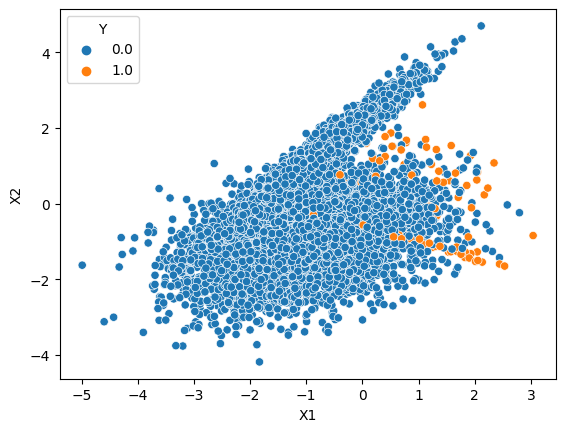

In [105]:
sns.scatterplot(data=df,x="X1",y="X2",hue=df['Y'])
plt.show()

##### inference- it is very hard to classify between 0's and 1's 

<a id="9"></a> <br>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 9. The One-Class SVM </h2>
</div>
 
A One-Class Support Vector Machine is an unsupervised learning algorithm that is trained only on the ‘normal’ data, in our case it's the class 0 i.e majority class. It learns the boundaries of these points and is therefore able to classify any points that lie outside the boundary as outliers. These points are nothing but class 1 or minority class

 
How imbalanced learning algorithms generally work is to connect points of a certain class, and create new observations along the lines that connect those points. This works great when there is a clear planar separation between the classes, but when there is not, you observe no improvement in the performance of the model. Hence let's go for one-class SVM

 

In [108]:
# import OneClassSVM function from sklearn.svm
from sklearn.svm import OneClassSVM 

# Compute Outlier Proportion - A param
train, test = train_test_split(churn_data, test_size=.3) 
train_normal = train[train['Exited']==0] 
train_outliers = train[train['Exited']==1] 
outlier_prop = len(train_outliers) / len(train_normal) 
outlier_prop

0.2598992080633549

__Redefine classification model for One Class SVM__

In [109]:
# Define the function to create classificatio model and get the evaluation metrices
def classification_model(X,y,class_weight = None):
    # Split the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size = 0.33, 
                                                        random_state = 0)
    
    train_normal = X_train[y_train==0] 
    test_normal = X_test[y_test==0] 
    test_outliers = X_test[y_test==1] 

    # Scale the features as we don't want one independent variable to dominate the others and additionally it makes computations easy
    sc = StandardScaler()
    train_normal = sc.fit_transform(train_normal)
    X_test = sc.transform(X_test)
    
    # Define the model
    # gamma controls how smooth the contour lines around the population are.
    svm = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=0.000001) 

    # Train the model
    svm.fit(train_normal)

    # Predicting target values on x_test dataset
    y_predicted = svm.predict(X_test)
    y_predicted = np.where(y_predicted==-1, 1, 0)  # preds are -1 and +1
    y_predicted_prob = svm.score_samples(X_test)  # pred proba does not exist for svm one class.
    return(svm, X_test, y_test, y_predicted, y_predicted_prob)

In [110]:
# Define the function to get the evaluation metrices
def compute_evaluation_metric(model, x_test, y_actual, y_predicted, y_predicted_prob):
    cm = confusion_matrix(y_actual, y_predicted)
    print("\n Accuracy Score : ",accuracy_score(y_actual,y_predicted))
    print("\n AUC Score : ", roc_auc_score(y_actual, y_predicted_prob))
    print("\n Confusion Matrix : \n", cm)
    TP = sum([1 if ((i==1) & (j==1)) else 0 for (i, j) in zip(y_test, y_predicted)])
    TN = sum([1 if ((i==0) & (j==0)) else 0 for (i, j) in zip(y_test, y_predicted)])
    FP = sum([1 if ((i==0) & (j==1)) else 0 for (i, j) in zip(y_test, y_predicted)])
    FN = sum([1 if ((i==1) & (j==0)) else 0 for (i, j) in zip(y_test, y_predicted)])
    # Sensitivity, recall
    TPR = round(TP/(TP+FN), 4)
    # Specificity
    TNR = round(TN/(TN+FP), 4)
    # False Pos Rate
    FPR = round(FP/(FP+TN), 4)
    # False Neg rate
    FNR = round(FN/(TP+FN), 4)
    print("\n Classification Report : \n",classification_report(y_actual, y_predicted))
    print("TPR, TNR, FPR, FNR:" , TPR, TNR, FPR, FNR)

__Build Model__

In [111]:
# Build the model on unbalanced dataset and use class_weight = 'balanced' for logistic regression and get the evaluation metrices
sv_model, X_test, y_test, y_predicted, y_predicted_prob = classification_model(X_original, y_original, class_weight = weights)

In [118]:
sv_model


OneClassSVM(gamma=1e-06, nu=0.2598992080633549)

__Evaluate__

In [119]:
compute_evaluation_metric(sv_model, X_test, y_test, y_predicted, y_predicted_prob)


 Accuracy Score :  0.6487878787878788

 AUC Score :  0.34838433913632627

 Confusion Matrix : 
 [[1769  848]
 [ 311  372]]

 Classification Report : 
               precision    recall  f1-score   support

           0       0.85      0.68      0.75      2617
           1       0.30      0.54      0.39       683

    accuracy                           0.65      3300
   macro avg       0.58      0.61      0.57      3300
weighted avg       0.74      0.65      0.68      3300

TPR, TNR, FPR, FNR: 0.5447 0.676 0.324 0.4553


In [120]:
# name, accuracy, F1, ROC, TPR, TNR, FPR, FNR
base                = ["reference",  0.81, 0.33, 0.77, 0.2255, 0.9595, 0.0405, 0.7745]

# cost sensitive
oneclass_SVM  = ["oneclass_SVM", 0.66, 0.39, None, 0.5481, 0.675, 0.325, 0.4519]

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h4 style='margin:10px 5px'> Inferences:</h4>
</div>

- Relatively, this technique didn't perform well on this dataset compared to the other methods. However, this cannot be generalized for all datasets. This can turn out to be a useful tool when the data points are [well separated](https://towardsdatascience.com/outlier-detection-with-one-class-svms-5403a1a1878c). 


<a id="10"></a> <br>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 10. Using Mahalonobis Distance </h2>
</div>

Ref: https://www.machinelearningplus.com/statistics/mahalanobis-distance/

Mahalanobis distance is an effective multivariate distance metric that measures the distance between a point and a distribution. It is an extremely useful metric having, excellent applications in multivariate anomaly detection, classification on highly imbalanced datasets and one-class classification.

Let's see, how is Mahalanobis distance different from Euclidean distance?

- It transforms the columns into uncorrelated variables
- Scale the columns to make their variance equal to 1
- Finally, it calculates the Euclidean distance.

In [121]:
# Split the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X_original, y_original, test_size = 0.33, random_state = 0)

__Mahalanobis Distance Formula__
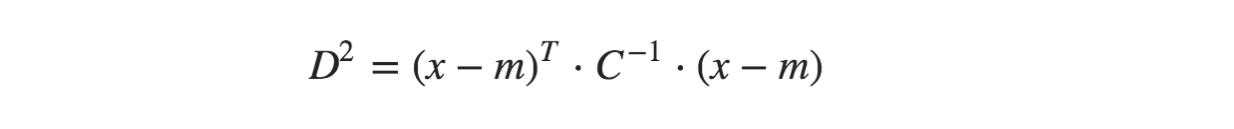

In [122]:
import scipy as sp

def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()


class MahalanobisBinaryClassifier():
    def __init__(self, X_train, y_train):
        self.xtrain_pos = X_train.loc[y_train == 1, :]
        self.xtrain_neg = X_train.loc[y_train == 0, :]

    def predict_proba(self, X_test):
        pos_neg_dists = [(p,n) for p, n in zip(mahalanobis(X_test, self.xtrain_pos), mahalanobis(X_test, self.xtrain_neg))]
        return np.array([(1-n/(p+n), 1-p/(p+n)) for p,n in pos_neg_dists])

    def predict(self, X_test):
        return np.array([np.argmax(row) for row in self.predict_proba(X_test)])


clf = MahalanobisBinaryClassifier(X_train, y_train)        
pred_probs = clf.predict_proba(X_test)
pred_class = clf.predict(X_test)

# Pred and Truth
pred_actuals = pd.DataFrame([(pred, act) for pred, act in zip(pred_class, y_test)], columns=['pred', 'true'])       

__Probability Scores__

In [124]:
# P(Pos), P(Neg)
pred_probs[:6]

array([[0.45423483, 0.54576517],
       [0.44250662, 0.55749338],
       [0.5363483 , 0.4636517 ],
       [0.53848079, 0.46151921],
       [0.46558506, 0.53441494],
       [0.37837883, 0.62162117]])

__Predictions vs Actuals__

In [125]:
pred_actuals.head()

,pred,true
0,1,0
1,1,1
2,0,0
3,0,0
4,1,0


In [126]:
print(classification_report(pred_actuals['true'],pred_actuals['pred']))

              precision    recall  f1-score   support

           0       0.94      0.58      0.72      2617
           1       0.35      0.85      0.49       683

    accuracy                           0.64      3300
   macro avg       0.64      0.72      0.61      3300
weighted avg       0.82      0.64      0.67      3300



In [127]:
# name, accuracy, F1, ROC, TPR, TNR, FPR, FNR
base                = ["reference",  0.81, 0.33, 0.77, 0.2255, 0.9595, 0.0405, 0.7745]

# cost sensitive
mahalanobis  = ["Mahalanobis", 0.63, 0.48, None, 0.82, 0.59, 0.41, 0.18]

<div class="alert alert-info" style="padding:0px 10px; border-radius:5px;"><h4 style='margin:10px 5px'> Inferences:</h4>
</div>

- The accuracy has reduced as compared to the model buit on original dataset but now the model is in a good state to precict the 1's as well, the precision recall and f-1 score has improved for class 1 as well.

<a id="11"></a> <br>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 11. Isolation Forest for One Class Classification </h2>
</div>

In [128]:
from sklearn.ensemble import IsolationForest

# define outlier detection model
model = IsolationForest(contamination=0.01, n_estimators=100)

In [129]:
y_train.value_counts(normalize=True)

0    0.79791
1    0.20209
Name: Exited, dtype: float64

__Train Model__

In [130]:
# fit on majority class
train_data = X_train[y_train==0]
model.fit(train_data)

IsolationForest(contamination=0.01)

__Predict__

In [131]:
pred = model.predict(X_test)
pred = np.where(pred==-1, 0, 1)
np.unique(pred, return_counts=True)

(array([0, 1]), array([  58, 3242], dtype=int64))

__Report__

In [132]:
# classification Report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.50      0.01      0.02      2617
           1       0.20      0.96      0.33       683

    accuracy                           0.21      3300
   macro avg       0.35      0.48      0.18      3300
weighted avg       0.44      0.21      0.09      3300



<a id="11"></a> <br>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 11. Probability Threshold Tuning</h2>
</div>

Depending on the problem objectives you might want to check if the model achieves a better performance at a different probability threshold. 

Let's tune the threshold.

In [108]:
# Define the function to create classificatio model and get the evaluation metrices
def classification_model(X,y,class_weight = None):
    # Split the dataset into the Training set and Test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)
    
    # Scale the features as we don't want one independent variable to dominate the others and additionally it makes computations easy
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    # Define the model
    lr = LogisticRegression(class_weight = class_weight, random_state=0)

    # Train the model
    lr.fit(X_train, y_train)
    return (lr, X_test)

    
def results(lr, X_test, threshold=0.5):
    # Predicting target values on x_test dataset
    # y_predicted = lr.predict(X_test)
    y_predicted_prob = lr.predict_proba(X_test)
    y_predicted_prob = [x[1] for x in y_predicted_prob]
    y_predicted = [1 if p > threshold else 0 for p in  y_predicted_prob]
    return(y_test, y_predicted, y_predicted_prob, threshold)

In [146]:
from sklearn.metrics import precision_score, f1_score

In [156]:
# Define the function to get the evaluation metrices
def compute_evaluation_metric(y_actual, y_predicted, y_predicted_prob, threshold):
    accuracy = round(accuracy_score(y_actual,y_predicted), 3)
    TP = sum([1 if ((i==1) & (j==1)) else 0 for (i, j) in zip(y_test, y_predicted)])
    TN = sum([1 if ((i==0) & (j==0)) else 0 for (i, j) in zip(y_test, y_predicted)])
    FP = sum([1 if ((i==0) & (j==1)) else 0 for (i, j) in zip(y_test, y_predicted)])
    FN = sum([1 if ((i==1) & (j==0)) else 0 for (i, j) in zip(y_test, y_predicted)])
    # Sensitivity, recall
    TPR = round(TP/(TP+FN), 4)
    # Specificity
    TNR = round(TN/(TN+FP), 4)
    # False Pos Rate
    FPR = round(FP/(FP+TN), 4)
    # False Neg rate
    FNR = round(FN/(TP+FN), 4)
    youdens = round(TPR + TNR - 1, 3)
    precision = round(precision_score(y_actual, y_predicted), 3)
    f1 = round(f1_score(y_actual, y_predicted), 3)
    # print("TPR, TNR, FPR, FNR, accuracy, auc, Youdens:" , TPR, TNR, FPR, FNR, accuracy, youdens, round(youdens, 3))
    return(round(threshold, 3), TPR, TNR, precision, youdens, f1)

__Build Model__

In [157]:
# Build the model on original dataset and get the evaluation metrices
lr, X_test,  = classification_model(X_original,y_original)

__Iterate and evaluate for all thresholds__

In [158]:
output = []
for i in np.linspace(0, 1, 50):
    y_test, y_predicted, y_predicted_prob, threshold = results(lr, X_test, threshold=i)
    output.append(compute_evaluation_metric(y_test, y_predicted, y_predicted_prob, i))

In [159]:
# Threshold, TPR, TNR, youdens, precision, f1
pd.DataFrame(output, columns=['Threshold', 'TPR', 'TNR', 'Precision', 'Youdens', 'F1'])

,Threshold,TPR,TNR,Precision,Youdens,F1
0,0.000,1.0000,0.0000,0.207,0.000,0.343
1,0.020,0.9956,0.0069,0.207,0.002,0.343
2,0.041,0.9883,0.0757,0.218,0.064,0.357
3,0.061,0.9707,0.1731,0.235,0.144,0.378
4,0.082,0.9400,0.2828,0.255,0.223,0.401
5,0.102,0.9092,0.3756,0.275,0.285,0.423
6,0.122,0.8712,0.4547,0.294,0.326,0.440
7,0.143,0.8360,0.5311,0.318,0.367,0.460
8,0.163,0.7965,0.5972,0.340,0.394,0.477
9,0.184,0.7570,0.6454,0.358,0.402,0.486
